<a href="https://colab.research.google.com/github/naorJR/IP-Labs/blob/ortra/Lab%206/Lab6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Lab 6 - JPEG Compressionend </center></h1>

## Goal: Introduction of principles of the JPEG baseline coding system.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd '/content/drive/My Drive/IP Labs/6/'
%ls
import os
path = os.getcwd() 
print('path: ' + path)

/content/drive/My Drive/IP Labs/6
0.jpg  1  10  100  4  60  bean.jpg  ex6_pre_code.ipynb  Lab6_v2.ipynb
path: /content/drive/My Drive/IP Labs/6


Import the necessary libraries:

In [3]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_ubyte
from skimage import restoration
import sys
import math
from skimage.color import rgb2gray
from PIL import Image
from scipy import fftpack

# 1. Helper Functions

In this section you will implement several helper functions which will be used in your implementation of JPEG compression and decompression. 

The functions ***quantize*** and ***dequantize*** are given:



In [4]:
def load_quantization_table(quality,block_size):
    q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])* quality   # JPEG normalizing array and zig-zag reordering
    if (block_size != 8):
        q = transform.resize(q, (block_size, block_size), preserve_range=True)
    return q

def quantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return np.array((block / q).round().astype(np.int32))

def dequantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return block * q

1.   Complete the funcion ***zigzag(M,N)*** written in the preliminary report:

In [5]:
def zigzag(M,N):
  ## Your code here ##
  x = np.arange(M*N).reshape(M,N)
  if M%2 == 0 :
    order = np.concatenate([np.diagonal(x[::-1,:], i)[::(2*((i+1) % 2)-1)] for i in range(1-x.shape[0], x.shape[0]+1)])
  else :
    order = np.concatenate([np.diagonal(x[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-x.shape[0], x.shape[0]+1)])
  return order

2.   Implement ***block_to_zigzag(block, order)***

This function transforms a *block_size* x *block_size* block of your image to a 1D array ordered according to the list of indices given in *order*. 

Hint: Use block.flatten()

3.   Implement ***zigzag_to_block(zigzag, order)***

This function performs the inverse operation. Given a 1D array ordered according to the list of indices given in *order*, it transforms it to a **square** block with its elements in their original location.


In [6]:
def block_to_zigzag(block,order):
  ## Your code here ## 
  return block.flatten()[order]

def zigzag_to_block(zigzag,order,s):
   ## Your code here ## 
  zigzag = zigzag.reshape(s)
  block = np.zeros_like(zigzag)
  order = order.reshape(zigzag.shape)
  block[np.unravel_index(order, order.shape)] = zigzag

  return block

4. Implement 2D DCT and IDCT.

Expand your 1D function ***my_dct*** to 2D. Here you may use ***fftpack.dct*** and ***fftpack.idct***.

In [7]:
def dct_2d(image):
  ## Your code here ##
  return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def idct_2d(image):
  ## Your code here ##
    #image[image>127] =127
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')    


# 2. JPEG Compression and Decompression

1.   Load and show the image of your choice (grayscale). Covert it to uint32.



In [8]:
class Images():
    def __init__(self, image, title):
        self.image = image
        self.title = title

def plotImages(images,dim, size=(20, 15)):                                               
  fig, ax = plt.subplots(dim[0],dim[1],figsize=size)
  ax = ax.ravel()
  for i,image in enumerate(images):
    ax[i].imshow(image.image, cmap='gray',vmin = 0,vmax = 255)
    ax[i].set_title(image.title)
    ax[i].set_xlabel('Width [px]')
    ax[i].set_ylabel('Height [px]')
  plt.tight_layout()

  plt.show()

Image shape:(400, 400), Image data type:uint32


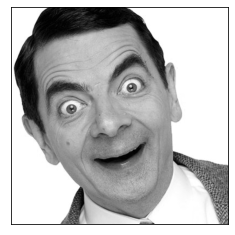

In [9]:
# Insert your answer here
img = rgb2gray(io.imread('bean.jpg'))
img = img_as_ubyte(img).astype('uint32')
print ('Image shape:{}, Image data type:{}'.format(img.shape,img.dtype))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X & Y axis
plt.show()

Lets test our dct and idct implementions :

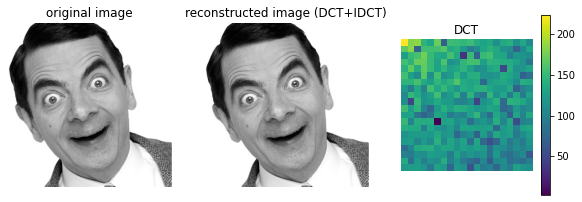

In [14]:
img_dct = dct_2d(img)
im = idct_2d(img_dct)
plt.subplots(figsize = (10,10))
plt.subplot(131), plt.imshow(img,cmap = 'gray'), plt.axis('off'), plt.title('original image')
plt.subplot(132), plt.imshow(im,cmap = 'gray'), plt.axis('off'), plt.title('reconstructed image (DCT+IDCT)')
plt.subplot(133), plt.imshow(20*np.log(np.abs(img_dct[0:20,0:20])+1)), plt.axis('off'), plt.title('DCT')
plt.colorbar(shrink=0.33)
plt.show()

2.   Complete the missing code in the following ***im2jpeg*** implementation of JPEG compression and decompression.



In [15]:
# im2jpeg Compresses an image using a JPEG approximation.
# im2jpeg(img,block_size, quality) compresses image based on block_size x block_size DCT transforms and coefficient quantization.
# Input quality determines the amount of information that is lost and compression achieved. 

def im2jpeg(img, block_size=8, quality=1):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint32: 
        print("The input must be a UINT32 image.")
        return
    rows, cols = img.shape[0], img.shape[1]
    # block size: (block_size x block_size)
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of {}".format(block_size)))

    # End-Of-Block (EOB) symbol
    eob = 256
    jpeg_list = list()
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # loop over image blocks
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
                # Code the following steps
                # 1. extract a block of size block_size x block_size and center the data range on zero: [0, 255] --> [-128, 127]:
                ## Your code here ##
                block = img[i:i+block_size,j:j+block_size]
                block = block.astype('float64') -128

                # 2. perform dct to the block:
                ## Your code here ##
                block_dct = dct_2d(block)

                # 3. quantize your dct block using given quality factor:
                ## Your code here ##
                block_q = quantize(block_dct, quality, block_size)

                # 4. reorder in a zigzag pattern
                ## Your code here ##
                block_zigzag = block_to_zigzag(block_q, order)

                # 5. omit trailing zeros in reordered block
                ## Your code here ##
                t = np.trim_zeros(block_zigzag)

                
                # 6. add eob in the end of the block
                ## Your code here ##
                coded_block = np.append(t,eob)
                
                # 7. append the dct block to the list
                jpeg_list.append(coded_block)
                
    #convert the list to array
    jpeg_array = np.concatenate(jpeg_list,axis=None)
    return jpeg_array



# jpeg2im Decodes an IM2JPEG compressed image.
# jpeg2im(jpeg_img,block_size,quality) decodes compressed image jpeg_img, generating reconstructed approximation X. 
# jpeg_img is generated by im2jpeg.

def jpeg2im(jpeg_img, block_size=8, quality = 1):
    eob = 256
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # find the End-Of-Block (EOB) symbols
    ends_of_blocks = np.where(jpeg_img == eob)[0]
    num_of_block = ends_of_blocks.shape[0]
    
    # assuming that the image height and width are equal
    image_side = int(math.sqrt(num_of_block)) * block_size
    blocks_per_line = image_side // block_size
    
    # create new empty image: 
    npmat = np.empty((image_side, image_side), dtype=np.int32)
    
    start = 0
    for block_index, end in enumerate(ends_of_blocks):
        # 1. initialize new block
        zz_list = np.zeros(block_size*block_size)

        # 2. assign values from jpeg_img into beginning of zz_list
        zz_list[:end-start] = jpeg_img[start:end]

        # 3. convert zz_list back into block
        quant_matrix = zigzag_to_block(zz_list, order,(block_size,block_size))

        # 4. dequnatize
        dct_matrix = dequantize(quant_matrix,quality,block_size)

        # 5. perform idct to block
        block = idct_2d(dct_matrix)

        # find the place in the image to put the block
        i = (block_index // blocks_per_line * block_size) 
        j = (block_index % blocks_per_line * block_size)
        npmat[i:i+block_size, j:j+block_size] = block + 128
        start = end + 1
    
    return npmat
    

3. Compress your image using the JPEG compression algorithm calling ***im2jpeg*** and restore the image from its compressed form calling ***jpeg2im***.   
    * Present the original and restored images.
    * Print the number of elements in the original and compressed images. 
    * Explain why blocking effects can be seen in the restored image.   
    * Show the blocking effects by zooming in for intresting parts of the image. 

In [16]:
jpeg_img = im2jpeg(img,8,1)
restored = jpeg2im(jpeg_img,8,1)

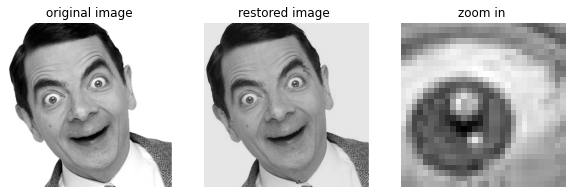

In [17]:
plt.subplots(figsize = (10,10))
plt.subplot(131), plt.imshow(img,cmap = 'gray'), plt.axis('off'), plt.title('original image')
plt.subplot(132), plt.imshow(restored,cmap = 'gray'), plt.axis('off'), plt.title('restored image ')
plt.subplot(133), plt.imshow(restored[170:200,100:130],cmap = 'gray'), plt.axis('off'), plt.title('zoom in ')
plt.show()

In [18]:
print ('Image number of elements : {}'.format(img.nbytes))
print ('Compressed Image number of elements : {}'.format(jpeg_img.nbytes))

Image number of elements : 640000
Compressed Image number of elements : 270832


Write your answer here
#### Answer 1
---
Given the block-based nature of the algorithm, it is possible that blocking artifacts will appear at the block boundaries.Blocking artifacts can be seen in the restored image because each block is transformed and quantized independently .the quantization process discards some of the high-frequency DCT coefficients, which contain the fine details and high-frequency components of the image.

As a result, the restored image may appear blocky or pixelated, especially in areas with sharp transitions or high-frequency content. The blocking effect can be more pronounced for images that have been heavily compressed or for areas of the image with high-frequency content.

---

# 3. Analysis

1. Plot the graph of compression ratio (Y axis) versus a “quality” parameter of *im2jpeg* (X axis). Use the supplied function *imratio*.  

Use the following quality parameters: 1,2,4,6,8,10,12,16,20,25

__Remark:__ the “quality” parameter defines the quality of compression and not the quality of restoration. It is defined to be greater or equal to 1. The “quality” equal to 1 corresponds to the best quality of restoration and the worst quality of compression.


In [19]:
def imratio(original_img1,compressed_img2):
    return float(compressed_img2.nbytes)/original_img1.nbytes

In [20]:
compression_ratio = []
Q = [1,2,4,6,8,10,12,16,20,25]

for q in Q:
  jpeg_img = im2jpeg(img,8,q) 
  compression_ratio.append(imratio(img,jpeg_img))

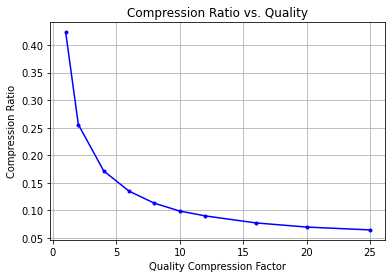

In [21]:
plt.plot(Q,compression_ratio,'b.-', label='Compression Ratio')

plt.title('Compression Ratio vs. Quality')
plt.ylabel('Compression Ratio')
plt.xlabel('Quality Compression Factor')
plt.grid()

plt.show()

Explain your results here
#### Answer 2
---
JPEG images use a variable quality level to control the amount of compression
we can see in load_quantization_table function that The greater  the quality setting, the greater the divisor, increasing the chance of a zero result. On the converse, the lower quality setting would have quantization table values of all 1's, meaning the all of the original DCT data is preserved. The values in the quantization table are chosen to preserve low-frequency information and discard high-frequency (noise-like) detail as humans are less critical to the loss of information in this area.

Each DCT term is divided by the corresponding position in the Quantisation table and then rounded to the nearest integer. In each table the low frequency terms are in the top left hand corner and the high frequency terms are in the bottom right hand corner. 

Indeed from the graph we see that the stronger the quality , the smaller the compressed image due to the zero result of the division between the dct to the quantization table(discard of high frequencies) .

---

2. The Root Mean Square (RMS) error of restoration is defined in the following way:  
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

    where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images.    
    
    Plot the graph of Root Mean Square (RMS) Error of restoration (Y axis) versus compression ratio (X axis). This graph is called Rate-Distortion curve.  
    
__Hint__: you can use the supplied functions *imratio*.



In [22]:
def calc_RMS(f, f_hat):
  # Insert your code:
  RMS = np.sqrt(np.mean((f-f_hat)**2))
  return RMS

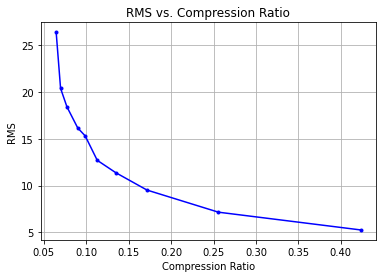

In [23]:
compression_ratio = []
rms = []
Q = [1,2,4,6,8,10,12,16,20,25]
for q in Q:
  jpeg_img = im2jpeg(img,8,q) 
  compression_ratio.append(imratio(img,jpeg_img))
  restored = jpeg2im(jpeg_img,8,q)
  rms.append(calc_RMS(img,restored))
plt.plot(compression_ratio,rms,'b.-', label='Compression Ratio')
plt.title('RMS vs. Compression Ratio')
plt.ylabel('RMS')
plt.xlabel('Compression Ratio')
plt.grid()

plt.show()

Explain your results here
#### Answer 3
---
Smaller ratio means smaller compressed image size, which means smaller number of elements in the image.
As expected, it is possible to see that smaller the compression ratio, the larger the RMS error.

In other words, the more brutal the compression, the worse the quality of the reconstruction.

---

3.	Repeat question 2.3 for block sizes __4X4__ and __16X16__. 
    * Compare blocking effects for different block sizes.   
    * Compare the compression of the algorithm for different block sizes.   
    * What are the advantages and disadvantages of changing the block size? 

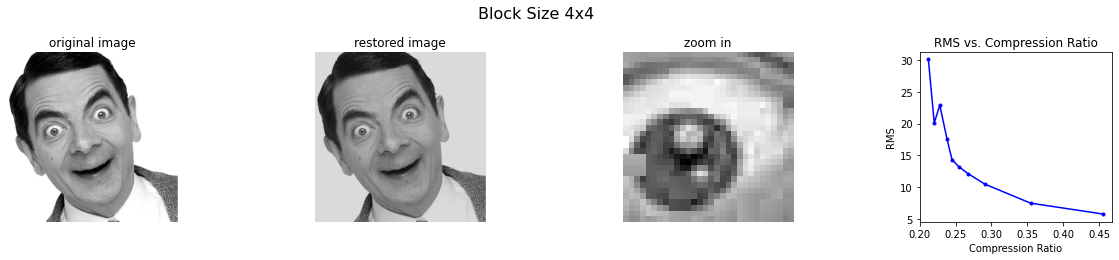

Image number of elements : 640000
Compressed Image number of elements : 135656



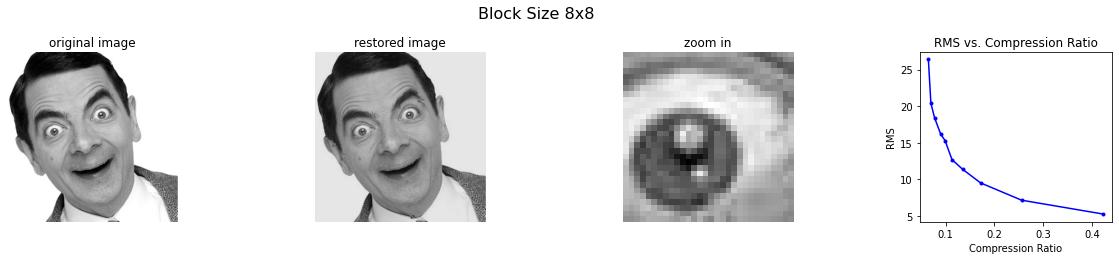

Image number of elements : 640000
Compressed Image number of elements : 41312



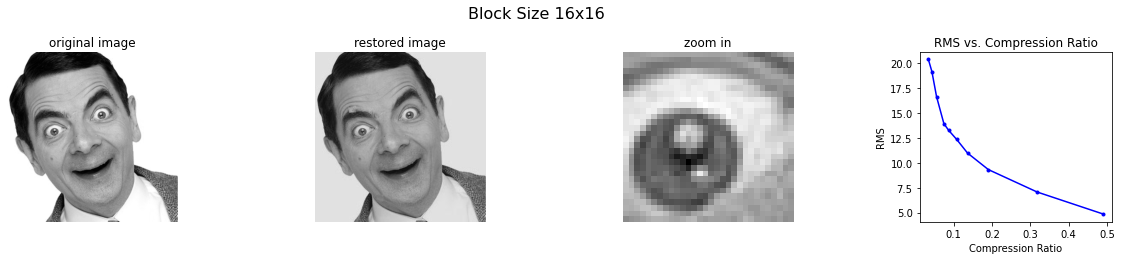

Image number of elements : 640000
Compressed Image number of elements : 21864



In [24]:
blocks = [4, 8, 16]
for b in blocks:
  jpeg_img = im2jpeg(img,b,1)
  restored = jpeg2im(jpeg_img,b,1)
  # Set the figure size
  plt.subplots(figsize = (20,3.5))
  plt.suptitle('Block Size {}x{}\n'.format(b,b), fontsize=16)
  # Adjust the spacing between subplots
  plt.subplots_adjust(wspace=0.6,top=0.8)
  plt.subplot(141), plt.imshow(img,cmap = 'gray'), plt.axis('off'), plt.title('original image')
  plt.subplot(142), plt.imshow(restored,cmap = 'gray'), plt.axis('off'), plt.title('restored image')
  plt.subplot(143), plt.imshow(restored[170:200,100:130],cmap = 'gray'), plt.axis('off'), plt.title('zoom in')
  compression_ratio = []
  rms = []
  Q = [1,2,4,6,8,10,12,16,20,25]
  for q in Q:
    jpeg_img = im2jpeg(img,b,q) 
    compression_ratio.append(imratio(img,jpeg_img))
    restored = jpeg2im(jpeg_img,b,q)
    rms.append(calc_RMS(img,restored))
  
  plt.subplot(144),plt.plot(compression_ratio,rms, 'b.-', label='Compression Ratio')
  plt.title('RMS vs. Compression Ratio')
  plt.ylabel('RMS')
  plt.xlabel('Compression Ratio')

  plt.show()
  
  print ('Image number of elements : {}'.format(img.nbytes))
  print ('Compressed Image number of elements : {}\n'.format(jpeg_img.nbytes))

Explain your results here
#### Answer 4
---
First, we can notice that the compression and reconstruction time decreased significantly when the block size increased.
We can also say that for larger blocks the the blocking artifacts will be more visible beacause we divided the image to larger blocks and we inticipate to see larger blocks in the blocking artifacts, so it is probably will affect the restoration.

In addition, we can see from the RMS graph that for small compression ratio (stronger compression), the bigger block is better while for less brutal compression the smaller size is preffered. 

Notice that it can be confirmed by the number of elements in each process per block size, while the number of elemtes will be smaller for the bigger block size. Which means that compression with larger block size is more agressive by definition.the reason behind it is for larger blocks we have more information per block and more redundancy

---

4. Use the following python build in function for JPEG compression:
        result = Image.fromarray((img).astype(np.uint8))
        result.save(Compressed_File_Name,"JPEG",optimize=True,quality= Your_quality)
   * Compress your image by using this function.
   * Load and show the compressed image. 
   * Compare the saved compressed image size in memory vs. the origonal image size.
   * Plot the compressed imag with quality of: 4, 10, 60.
   
   
__Note__: The 'quality' parameter is different here from the 'quality' parameter that we used in this lab implementation.


In [25]:
Q = [4,10,60,100]
for q in Q:
  Compressed_File_Name = str(q)
  result = Image.fromarray((img).astype(np.uint8))
  result.save(Compressed_File_Name,"JPEG",optimize=True,quality= q)

io.imsave('0.jpg', img, quality=100)

<ipython-input-25-4436b9f74983>:7: UserWarning: 0.jpg is a low contrast image
  io.imsave('0.jpg', img, quality=100)


<ipython-input-26-2e4105b74b03>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = rgb2gray(io.imread(str(q)))


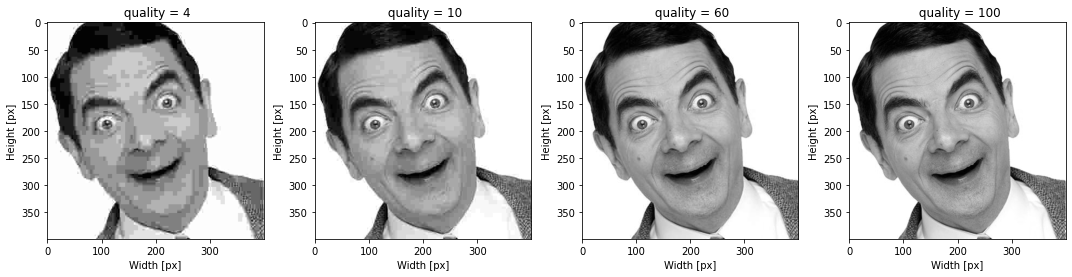


Quality 4 Image Size: 1KB
Quality 10 Image Size: 3KB
Quality 60 Image Size: 13KB
Quality 100 Image Size: 50KB

The Original Colored Image Size: 27KB


In [26]:
compressed_images = []
original_image_size = os.path.getsize('bean.jpg')
compressed_image_size = []
for q in Q:
  im = rgb2gray(io.imread(str(q)))
  im = img_as_ubyte(im).astype('uint32')
  compressed_images.append(Images(im," quality = " + str(q) ))
  compressed_image_size.append(os.path.getsize(str(q)))
plotImages(compressed_images, [1,4], (15, 10))
plt.show()

k=1024
print('')
for i in range(len(compressed_image_size)):
  print('Quality {} Image Size: {}KB'.format(Q[i] ,compressed_image_size[i]//k))

print('\nThe Original Colored Image Size: {}KB'.format(original_image_size//k))

<ipython-input-27-ef2500e5bb2f>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = rgb2gray(io.imread(str(q)))


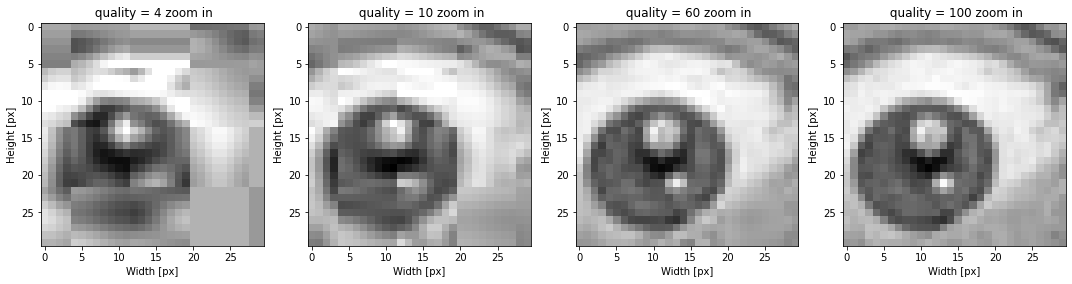

In [27]:
compressed_images = []
original_image_size = os.path.getsize('bean.jpg')
for q in Q:
  im = rgb2gray(io.imread(str(q)))
  im = img_as_ubyte(im).astype('uint32')
  compressed_images.append(Images(im[170:200,100:130]," quality = " + str(q) +" zoom in" ))
plotImages(compressed_images, [1,4], (15, 10))
plt.show()


Insert your answer here
#### Answer 5
---
JPEG images use a lossy compression algorithm. This algorithm trades quality for compression. A low-quality image results in a smaller JPEG file; a high-quality image generates a relatively large file.

The amount of JPEG compression is typically measured as a percentage of the quality level. An image at 100% quality has (almost) no loss, and 1% quality is a very low quality image. In general, quality levels of 90% or higher are considered "high quality", 80%-90% is "medium quality", and 70%-80% is low quality. Anything below 70% is typically a very low quality image.

In our example we can see that for low quality image  indeed the size is smaller - 

---